In [68]:
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import Nominatim
import geojson
import folium
from branca.colormap import LinearColormap, StepColormap

%matplotlib inline

## Let's load the data and have a peek at the contents

In [136]:
df = pd.read_csv('./data/round3/rew_round3_with_latlng.csv')
df.head()

,address,price,link,bed,bath,sqft,age,gross_taxes_2017,strata_maintenance_fees,area,sub_area,property_type,strata_type,listing_id,primary_broker,features,amenities,school_info,latlng
0,405-12 Athletes Way,999000,https://www.rew.ca/properties/R2219336/405-12-...,2,1,884,8.0,2153.0,516.0,Vancouver West,False Creek,Apt/Condo,Freehold Strata,R2219336,Team 3000 Realty Ltd.,"Air Conditioning, ClthWsh/Dryr/Frdg/Stve/DW, M...","Club House, Elevator, Exercise Centre, Garden,...","[{'name': 'Simon Fraser Elementary School', 'a...","(49.271554, -123.106738)"
1,604-1661 Ontario Street,1398000,https://www.rew.ca/properties/R2221859/604-166...,2,2,1189,9.0,2721.0,679.0,Vancouver West,False Creek,Apt/Condo,Freehold Strata,R2221859,Trg The Residential Group Rlty,"ClthWsh/Dryr/Frdg/Stve/DW, Microwave","Bike Room, Exercise Centre, In Suite Laundry, ...","[{'name': 'Simon Fraser Elementary School', 'a...",MISSING
2,204-1529 W 6th Avenue,699000,https://www.rew.ca/properties/R2220891/204-152...,0,1,719,21.0,1456.0,361.0,Vancouver West,False Creek,Apt/Condo,Freehold Strata,R2220891,Macdonald Realty,"Dishwasher, Garage Door Opener","Elevator, Restaurant, Storage, Wheelchair Access","[{'name': 'Henry Hudson Elementary School', 'a...",MISSING
3,106-1551 Mariner Walk,929000,https://www.rew.ca/properties/R2222093/106-155...,2,2,1094,29.0,1983.0,493.0,Vancouver West,False Creek,Apt/Condo,Leasehold prepaid-Strata,R2222093,Engel & Volkers Vancouver,"ClthWsh/Dryr/Frdg/Stve/DW, Disposal - Waste, D...","Elevator, Garden, In Suite Laundry, Storage","[{'name': 'Henry Hudson Elementary School', 'a...",MISSING
4,1103-1783 Manitoba Street,859000,https://www.rew.ca/properties/R2222252/1103-17...,2,1,714,3.0,2018.0,361.0,Vancouver West,False Creek,Apt/Condo,Freehold Strata,R2222252,Sutton Grp West Coast (Brdwy),"ClthWsh/Dryr/Frdg/Stve/DW, Disposal - Waste, D...","Bike Room, Club House, Elevator, Exercise Cent...","[{'name': 'Simon Fraser Elementary School', 'a...",MISSING


In [137]:
df.columns

Index(['address', 'price', 'link', 'bed', 'bath', 'sqft', 'age',
       'gross_taxes_2017', 'strata_maintenance_fees', 'area', 'sub_area',
       'property_type', 'strata_type', 'listing_id', 'primary_broker',
       'features', 'amenities', 'school_info', 'latlng'],
      dtype='object')

## Let's organize our variables into numerical (quantitative) and categorical (qualitative)

In [138]:
quantitative_vars = ['price', 
                     'bed', 
                     'bath', 
                     'sqft', 
                     'age', 
                     'gross_taxes_2017', 
                     'strata_maintenance_fees']
qualitative_vars = ['address', 
                    'area', 
                    'sub_area', 
                    'property_type', 
                    'strata_type', 
                    'primary_broker', 
                    'features', 
                    'amenities', 
                    'school_info', 
                    'latlng']
other_vars = ['link', 
              'listing_id']

## Get stats for all of the data

In [139]:
df.describe()

,price,bed,bath,sqft,age,gross_taxes_2017,strata_maintenance_fees
count,7.210000e+02,721.000000,721.000000,721.000000,712.000000,647.000000,346.000000
mean,2.754739e+06,3.490985,2.950069,2139.233010,-103.962079,5685.330757,421.225434
std,3.103278e+06,2.011837,1.776468,1547.853616,1032.562727,5677.014141,619.160138
min,2.250000e+05,0.000000,0.000000,0.000000,-7981.000000,0.000000,0.000000
25%,1.049000e+06,2.000000,2.000000,1039.000000,3.000000,1806.500000,245.250000
50%,1.848888e+06,3.000000,3.000000,1820.000000,19.500000,4477.000000,361.000000
75%,3.358800e+06,5.000000,4.000000,2852.000000,50.000000,7797.000000,461.000000
max,3.500000e+07,10.000000,8.000000,12619.000000,113.000000,58986.000000,9999.000000


## Wow, very large maximum albeit not suprising.  Let's have a closer look at the distribution of pricing

In [140]:
df.price.describe()

count    7.210000e+02
mean     2.754739e+06
std      3.103278e+06
min      2.250000e+05
25%      1.049000e+06
50%      1.848888e+06
75%      3.358800e+06
max      3.500000e+07
Name: price, dtype: float64

### Plot histogram of prices

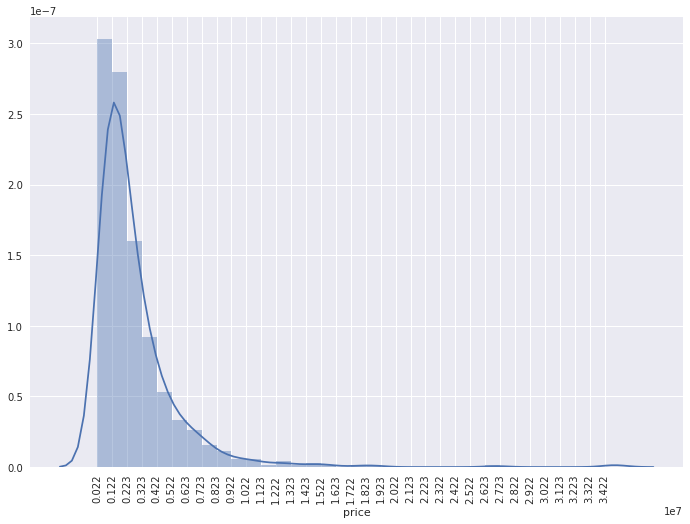

In [141]:
def plot_prices(df: pd.DataFrame, bins: list):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    fig, ax = plt.subplots()
    ax.set_xticks(bins)
    plt.xticks(rotation='vertical')
    return sns.distplot(df.price, bins=bins)

bins = range(int(df.price.min()),int(df.price.max()),1000000)
plot_prices(df, bins)

### Definitely a skewed distribution, looks as if we have a few outliers at the higher range of the prices. Check the skewness and kurtosis

In [142]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

Skewness: 4.937137
Kurtosis: 38.971564


## Plot with outliers removed

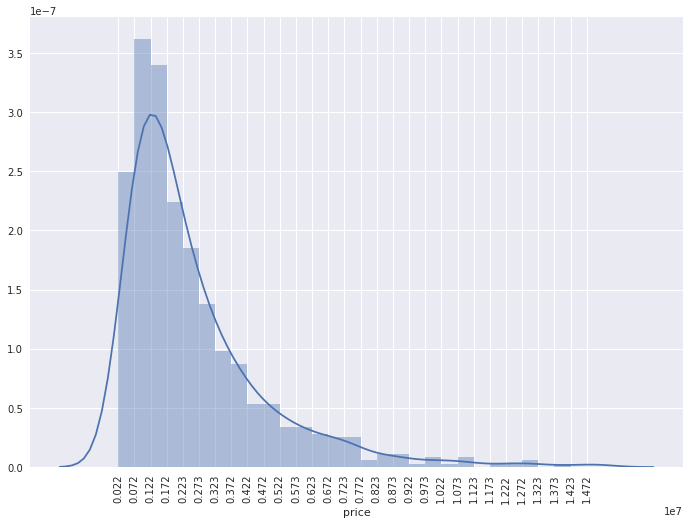

In [143]:
df_no_outliers = df[df.price < 15e6]
bins = range(int(df_no_outliers.price.min()),int(df_no_outliers.price.max()),500000)
plot_prices(df_no_outliers, bins)

## Plot data on a slippy map to see locations of housing

In [145]:
m = folium.Map(location=(49.271554, -123.106738))
colors = ['gray', 'green','blue','red','orange', 'yellow']
colormap = StepColormap(colors=colors,vmin=5e5, vmax=10e6, caption='price')
m.add_child(colormap)
for i, latlng in enumerate(df['latlng']):
    price = df.loc[i, 'price']
    if latlng is not None and latlng != 'MISSING':
        if isinstance(latlng, str):
            lat, lng = latlng.replace('(','').replace(')','').split(',')
            latlng = (float(lat), float(lng))
        if not isinstance(latlng, tuple):
            continue
        display_html = pd.DataFrame(df.loc[i, :]).to_html()
        style = {'fillColor': colormap(price),
                'color' : colormap(price)}
        p = geojson.Point(coordinates=(latlng[1], latlng[0]), style=style)
#         html_info = pd.DataFrame(df.loc[i][:1]).to_html()
#         html_info = None
        html_info = '<li>Price: ${}</li><li>{}</li>'.format(df.loc[i, 'price'], df.loc[i, 'age'])
        m.add_child(folium.Marker(location=latlng, icon=folium.Icon(color='black', icon_color=colormap(price)), popup=folium.Popup(html=html_info)))
m

## As expected, we see higher pricing closer to downtown with lower prices on the outer regions

## Next, let's see how some of the variables interact with the list price

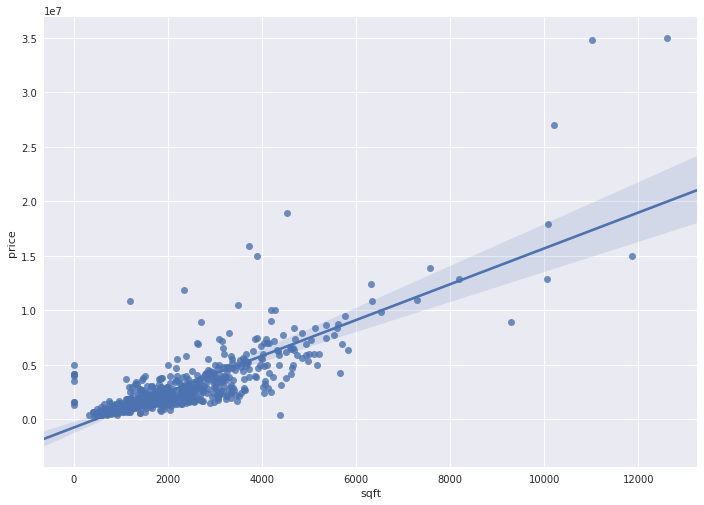

In [146]:
#ssqft/saleprice
var = 'sqft'
sns.regplot(df[var], df['price'], )

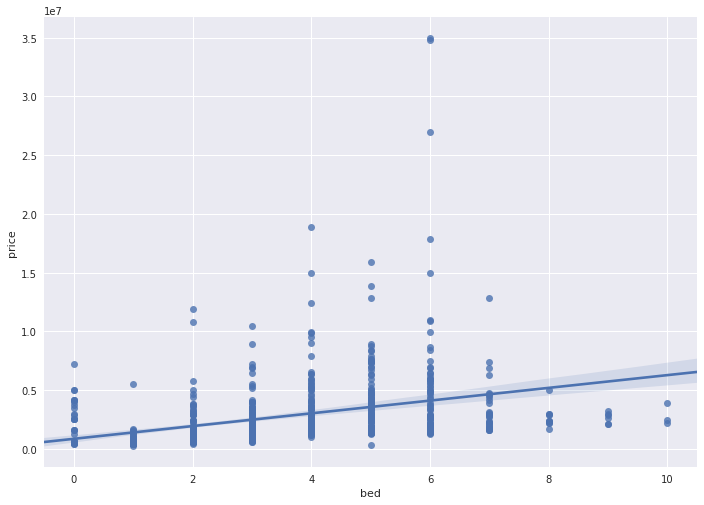

In [147]:
var = 'bed'
sns.regplot(df[var], df['price'], )

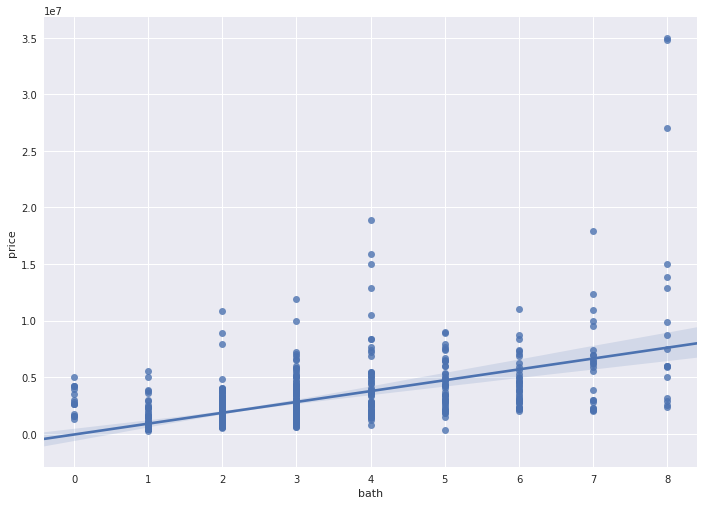

In [148]:
var = 'bath'
sns.regplot(df[var], df['price'], )

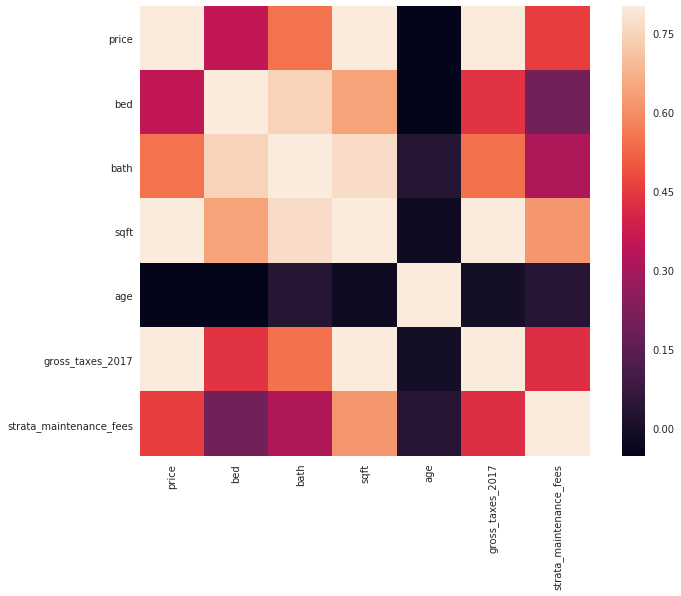

In [149]:
corrmat = df.corr()
sns.heatmap(corrmat, vmax=.8, square=True);

## Analyze the categorical variables

In [150]:
df.columns

Index(['address', 'price', 'link', 'bed', 'bath', 'sqft', 'age',
       'gross_taxes_2017', 'strata_maintenance_fees', 'area', 'sub_area',
       'property_type', 'strata_type', 'listing_id', 'primary_broker',
       'features', 'amenities', 'school_info', 'latlng'],
      dtype='object')

In [151]:
print(df.area.unique())
print(df.sub_area.unique())
print(df.strata_type.unique())
print(df.property_type.unique())


['Vancouver West' 'Vancouver East']
['False Creek' 'Downtown West' 'Yaletown' 'South Vancouver' 'Southlands'
 'West End' 'Victoria East' 'Southwest Marine' 'South Granville'
 'University (UBC)' 'Dunbar' 'Coal Harbour' 'Fairview' 'Collingwood'
 'Champlain Heights' 'Downtown East' 'Killarney' 'Fraser East' 'Hastings'
 'Hastings East' 'Kerrisdale' 'Fraserview East' 'Grandview East'
 'Mount Pleasant East' 'Knight' 'Renfrew Heights' 'South Cambie'
 'Quilchena' 'Oakridge' 'Marpole' 'MacKenzie Heights' 'Arbutus' 'Cambie'
 'Main' 'Kitsilano' 'Renfrew' 'Point Grey' 'Mount Pleasant West'
 'Shaughnessy']
['Freehold Strata' 'Leasehold prepaid-Strata' 'Freehold NonStrata'
 'Shares in Co-operative' 'Leasehold prepaid-NonStrata'
 'Leasehold not prepaid-NonStrata' 'Undivided Interest']
['Apt/Condo' 'House' 'Duplex' 'Townhouse' 'Land/Lot' 'Other' 'Triplex']


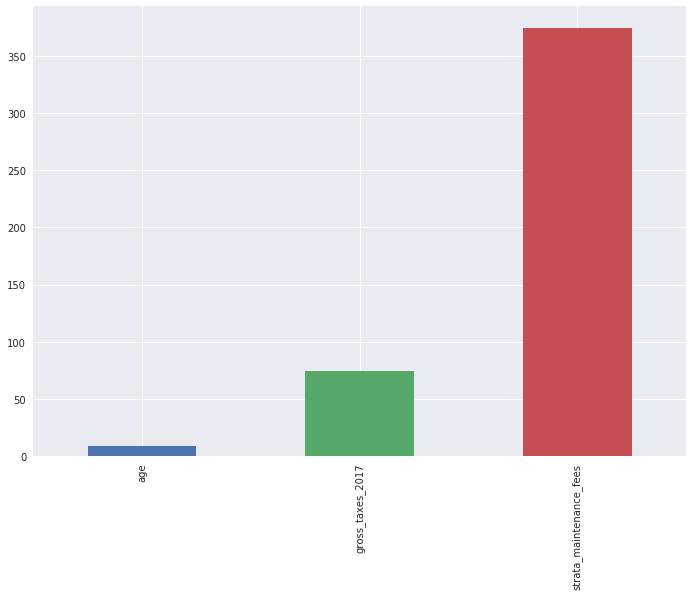

In [152]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

## convert age into a numerical value

In [153]:
# age_list = []
# for age in df['age']:
#     try:
#         split = age.split('(')
#         age = int(split[1].split(' ')[0])
#     except Exception as e:
#         age = None
#     finally:
#         age_list.append(age)
# df['age'] = age_list

In [156]:
df[df['age']<0] = None

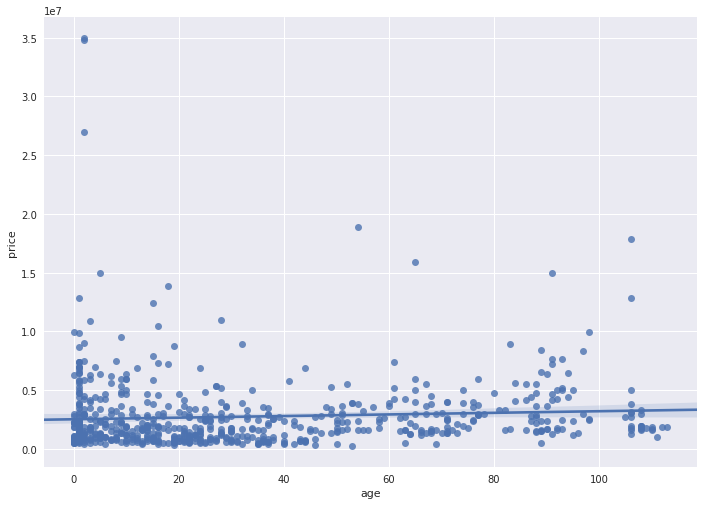

In [157]:
#age/saleprice
var = 'age'
sns.regplot(df[var], df['price'] )

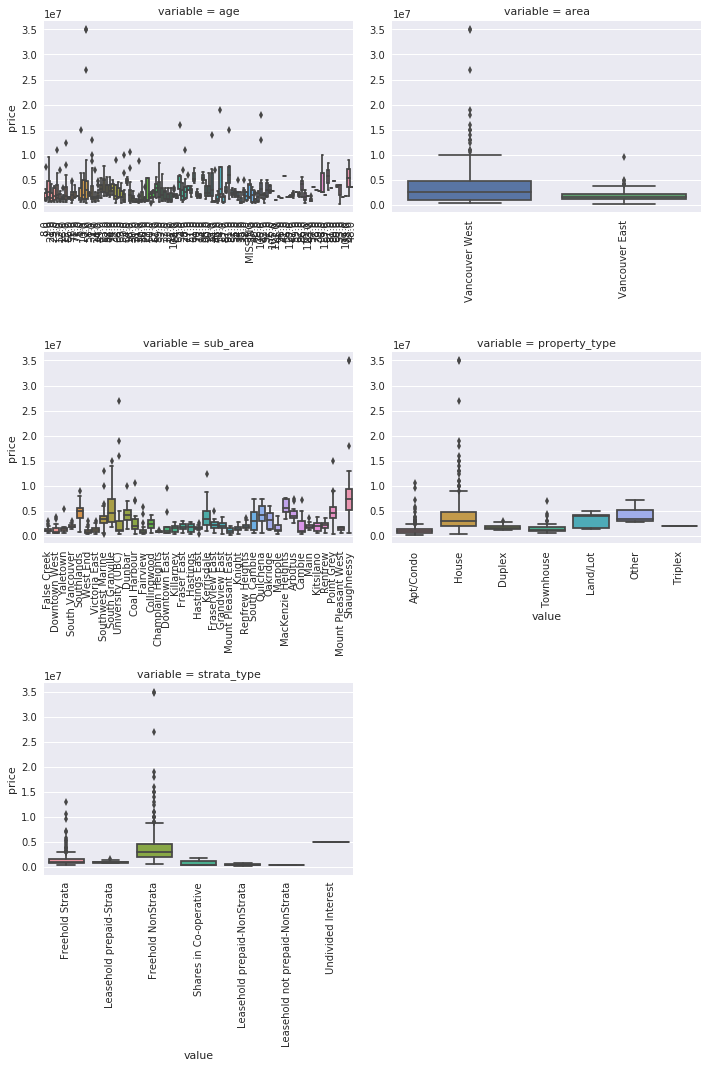

In [158]:
vars_to_analyize = ['age', 'area', 'sub_area', 'property_type', 'strata_type']
for c in vars_to_analyize:
    df[c] = df[c].astype('category')
    if df[c].isnull().any():
        df[c] = df[c].cat.add_categories(['MISSING'])
        df[c] = df[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(df, id_vars=['price'], value_vars=vars_to_analyize)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

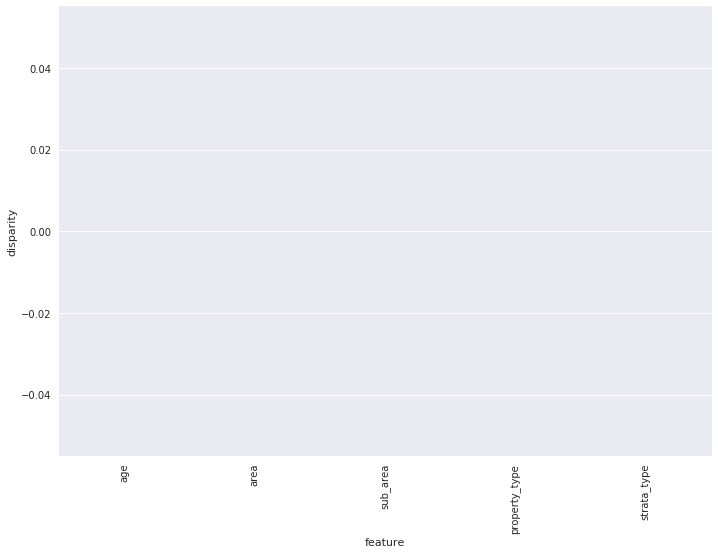

In [160]:
from scipy import stats
import numpy as np
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = vars_to_analyize
    pvals = []
    for c in vars_to_analyize:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['price'].values
            samples.append(s)
        try:
            pval = stats.f_oneway(*samples)[1]
        except Exception as e:
            pval=None
        finally:
            pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(df)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

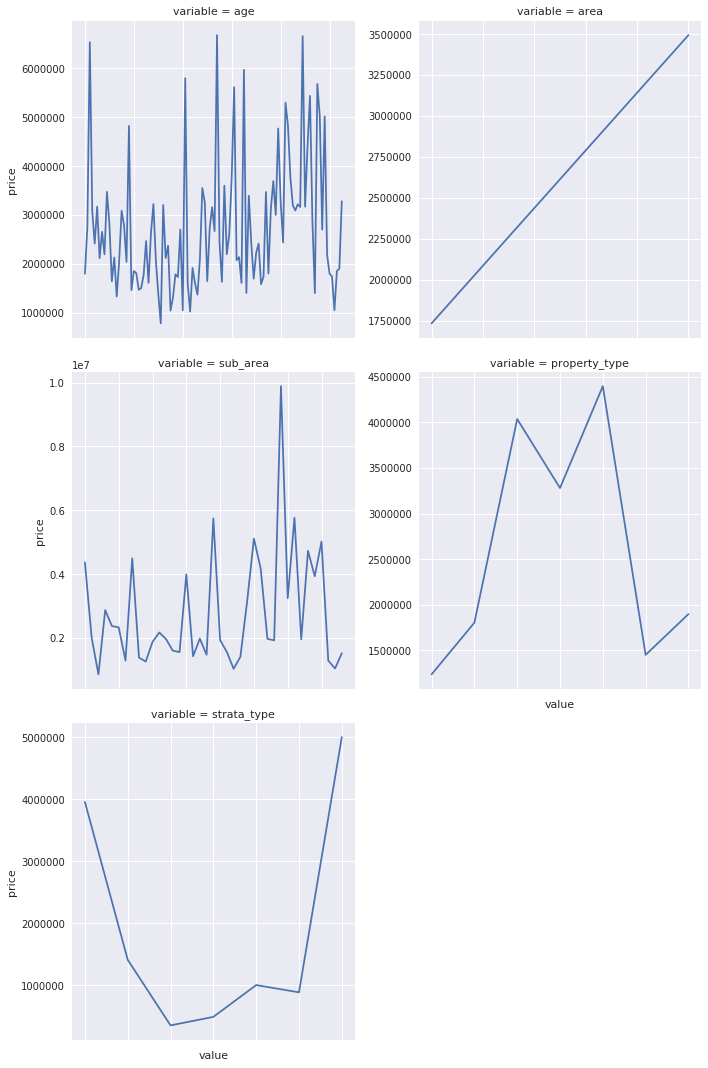

In [161]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(df, id_vars=['price'], value_vars=vars_to_analyize)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "price")

In [105]:
f.value.unique()

array([8.0, 9.0, 21.0, 29.0, 3.0, 12.0, 23.0, 15.0, 66.0, 6.0, 71.0, 75.0,
       5.0, 10.0, 2.0, 58.0, 1.0, 24.0, 14.0, 49.0, 93.0, 52.0, 88.0, 74.0,
       32.0, 68.0, 63.0, 84.0, 16.0, 30.0, 31.0, 19.0, 20.0, 36.0, 27.0,
       50.0, 17.0, 67.0, 89.0, 7.0, 33.0, 11.0, 22.0, 108.0, 64.0, 65.0,
       4.0, 28.0, 77.0, 51.0, 61.0, 70.0, 73.0, 94.0, 95.0, 90.0, 18.0,
       44.0, 46.0, 54.0, 13.0, 87.0, 91.0, 82.0, 55.0, 34.0, 35.0, 25.0,
       38.0, 37.0, 40.0, 26.0, 106.0, 42.0, 92.0, 76.0, 105.0, 111.0, 45.0,
       96.0, 41.0, 56.0, 110.0, 47.0, 59.0, 62.0, 86.0, 69.0, 112.0, 43.0,
       57.0, 78.0, 39.0, 98.0, 113.0, 97.0, 81.0, 80.0, 60.0, 53.0, 72.0,
       109.0, 83.0, 48.0, 'Vancouver West', 'Vancouver East',
       'False Creek', 'Downtown West', 'Yaletown', 'South Vancouver',
       'Southlands', 'West End', 'Victoria East', 'Southwest Marine',
       'South Granville', 'University (UBC)', 'Dunbar', 'Coal Harbour',
       'Fairview', 'Collingwood', 'Champlain Heights', 'Dow

# TODO: 
* ~~Scrape more data with more variables~~
* select features
* engineer features (dist to schools?, dist to city center?)
* Train a basic linear regressor
* Train a better model
* Train a neural network

## Let's use geocoding to get latlng coords of each house and add that to our DataFrame. We'll use these for visualizing on map later.

In [125]:
# Code below saved for reference of how we generated LatLng coords from address strings

# geocoder = Nominatim()
# def address_to_latlng(address: str, num_retries: int = 3) -> tuple:
#     """
#     Convert an address to a point in LatLng with geocoding
#     """
# #     print("search for {}".format(address))
#     for i in range(num_retries):
#         try:
#             location = geocoder.geocode(query=address + ', Vancouver BC')
#         except Exception as e:
#             time.sleep(2)
# #             print("Error: {}. Retrying...({} retries left)".format(e, num_retries - i - 1))
#             continue
#         break
        
#     if location is not None:
# #         print("found {}".format(location))
#         return (location.latitude, location.longitude)
# def add_latlng_column(df):
#     latlngs = []
#     for address in tqdm(df['address']):
#         latlng = address_to_latlng(address=address)
#         latlngs.append(latlng)
#     df['latlng'] = latlngs
# df = add_latlng_column(df)